In [77]:
import os.path
import math
import logging

import click
import tensorflow as tf
from matplotlib import pyplot as plt
from functools import partial
from tqdm import tqdm

In [78]:
logger = logging.getLogger(__name__)
logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s][%(levelname)s][%(name)s] %(message)s",
)

In [89]:
input_file = 'gs://flickr-faces-mini/32x32.tar'
tar_filename = os.path.basename(input_file)
# input_dir = 'gs://flickr-faces-mini/resized'
input_dir = './32x32'
output_dir = './output32x32'
img_size = 32
noise_dim = 24
batch_size = 256
shuffle_buffer_size = batch_size * 10

In [91]:
!mkdir -p {output_dir}/checkpoints {output_dir}/images

In [80]:
!gsutil cp {input_file} . && tar xf {tar_filename}

Copying gs://flickr-faces-mini/32x32.tar...
\ [1 files][ 99.0 MiB/ 99.0 MiB]                                                
Operation completed over 1 objects/99.0 MiB.                                     


In [81]:
def process_path(file_path: tf.Tensor, img_size: int) -> tf.Tensor:
    file_contents = tf.io.read_file(file_path)
    img = tf.io.decode_png(file_contents, channels=1)
    normalized_image = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return normalized_image

In [82]:
files_pattern = os.path.join(input_dir, "*", "*.png")
train_ds = (
    tf.data.Dataset.list_files(files_pattern, shuffle=False)
    .map(
        partial(process_path, img_size=img_size),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    .cache()
    .shuffle(shuffle_buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [83]:
cardinality = tf.data.experimental.cardinality(train_ds).numpy().tolist()
print(cardinality)

264


In [50]:
# plt.figure(figsize=(10, 10))
# for batch in train_ds.take(1):
#     batch_size, *_ = batch.shape
#     for i in range(batch_size):
#       plt.subplot(math.ceil(batch_size / 16), 16, i + 1)
#       plt.imshow(batch[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#       plt.axis('off')


In [84]:
def generate_and_save_images(
    output_dir: str, model: tf.keras.Model, epoch: int, test_input: tf.Tensor
) -> None:
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    batch_size, *_ = predictions.shape
    for i in range(batch_size):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig(os.path.join(output_dir, f"image_at_epoch_{epoch:04d}.png"))

In [104]:
def make_generator_model(*, img_size: int, noise_dim: int) -> tf.keras.Model:
    decoded_size = 4
    decoded_dims = 16
    noise = tf.keras.layers.Input(shape=(noise_dim,), name="noise")
    logger.debug("Noise dim %s", noise.shape)
    decoded = tf.keras.layers.Dense(
        decoded_size * decoded_size * decoded_dims, use_bias=False
    )(noise)
    decoded = tf.keras.layers.BatchNormalization()(decoded)
    decoded = tf.keras.layers.LeakyReLU()(decoded)
    logger.debug("Decoded dim %s", decoded.shape)

    reshaped = tf.keras.layers.Reshape(
        (decoded_size, decoded_size, decoded_dims)
    )(decoded)
    logger.debug("Reshaped dim %s", reshaped.shape)

    deconvoluted = tf.keras.layers.Conv2DTranspose(
        8, (3, 3), strides=(2, 2), padding="same", use_bias=False
    )(reshaped)
    deconvoluted = tf.keras.layers.BatchNormalization()(deconvoluted)
    deconvoluted = tf.keras.layers.LeakyReLU()(deconvoluted)
    logger.debug("Deconvoluted dim %s", deconvoluted.shape)

    deconvoluted = tf.keras.layers.Conv2DTranspose(
        4, (5, 5), strides=(2, 2), padding="same", use_bias=False
    )(deconvoluted)
    deconvoluted = tf.keras.layers.BatchNormalization()(deconvoluted)
    deconvoluted = tf.keras.layers.LeakyReLU()(deconvoluted)
    logger.debug("Deconvoluted dim %s", deconvoluted.shape)

    output = tf.keras.layers.Conv2DTranspose(
        1,
        (5, 5),
        strides=(2, 2),
        padding="same",
        use_bias=False,
        activation="tanh",
    )(deconvoluted)
    logger.debug("Output dim %s", output.shape)

    model = tf.keras.Model(inputs=noise, outputs=output)
    model.summary(print_fn=logging.debug)
    return model

In [105]:
def make_discriminator_model(*, img_size: int) -> tf.keras.Model:
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Conv2D(
            64,
            (5, 5),
            strides=(2, 2),
            padding="same",
            input_shape=[img_size, img_size, 1],
        )
    )
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(
        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same")
    )
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [106]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [107]:
with tf.distribute.MirroredStrategy().scope():
    generator = make_generator_model(img_size=img_size, noise_dim=noise_dim)
    discriminator = make_discriminator_model(img_size=img_size)

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

In [108]:
def discriminator_loss(
    cross_entropy, real_output: tf.Tensor, fake_output: tf.Tensor
) -> tf.Tensor:

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(cross_entropy, fake_output: tf.Tensor) -> tf.Tensor:
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [120]:
latest_checkpoint_dir = tf.train.latest_checkpoint(os.path.join(output_dir, 'checkpoints'))
if latest_checkpoint_dir:
  _, epoch_str = latest_checkpoint_dir.rsplit("-", 1)
  start_epoch = int(epoch_str)
  _ = checkpoint.restore(latest_checkpoint_dir)
  print("Loaded checkoint from", latest_checkpoint_dir)
else:
  print("No checkpoint to load")
  start_epoch = 0

Loaded checkoint from ./output32x32/checkpoints/ckpt-214


In [110]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 24])

In [121]:
@tf.function
def train_step(images: tf.Tensor) -> None:
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(cross_entropy, fake_output)
        disc_loss = discriminator_loss(
            cross_entropy, real_output, fake_output
        )

        gradients_of_generator = gen_tape.gradient(
            gen_loss, generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, discriminator.trainable_variables
        )

        generator_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )
        discriminator_optimizer.apply_gradients(
            zip(
                gradients_of_discriminator,
                discriminator.trainable_variables,
            )
        )

In [122]:
def train(dataset, epochs):
    generate_and_save_images(os.path.join(output_dir, 'images'), generator, start_epoch, seed)

    for epoch in range(start_epoch, epochs + start_epoch):
        for image_batch in tqdm(
            dataset,
            total=cardinality,
            desc=f"Epoch {epoch + 1}",
        ):
            train_step(image_batch)

        # Produce images for the GIF as you go
        generate_and_save_images(os.path.join(output_dir, 'images'), generator, epoch + 1, seed)

        checkpoint.save(file_prefix=os.path.join(output_dir, 'checkpoints', "ckpt"))

In [123]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise (InputLayer)          [(None, 24)]              0         
                                                                 
 dense_10 (Dense)            (None, 256)               6144      
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 256)               0         
                                                                 
 reshape_5 (Reshape)         (None, 4, 4, 16)          0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 8, 8, 8)          1152      
 Transpose)                                                

Epoch 234: 100%|██████████| 264/264 [00:09<00:00, 26.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
Epoch 314: 100%|██████████| 264/264 [00:09<00:00, 26.79it/s]


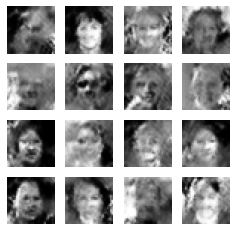

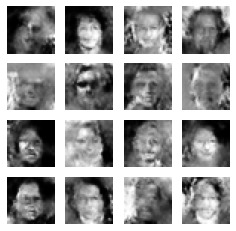

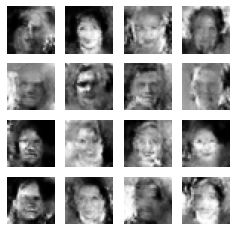

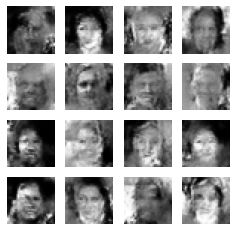

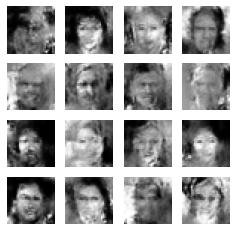

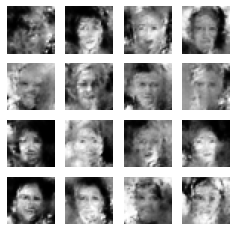

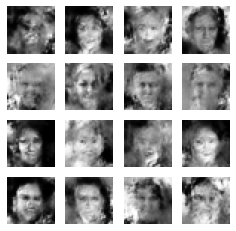

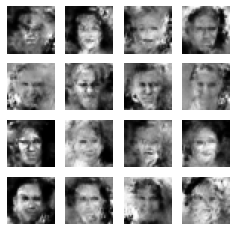

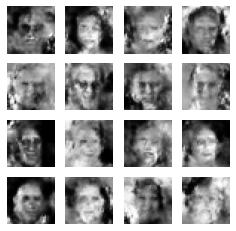

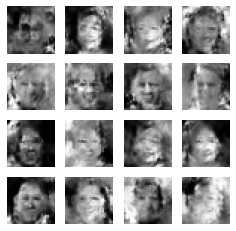

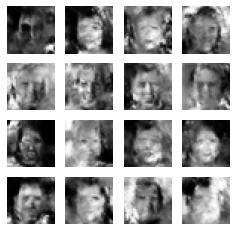

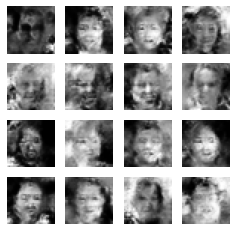

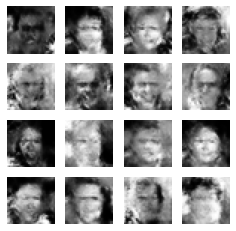

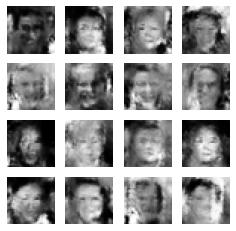

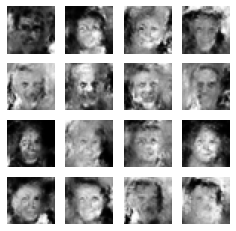

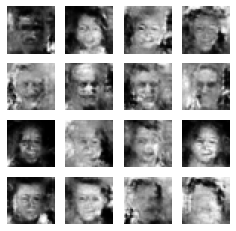

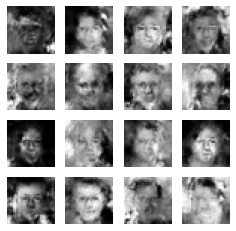

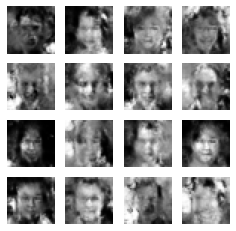

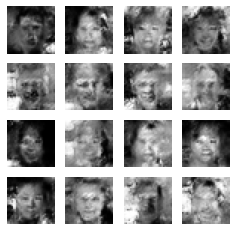

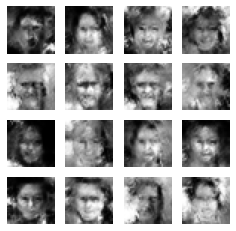

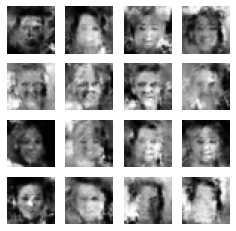

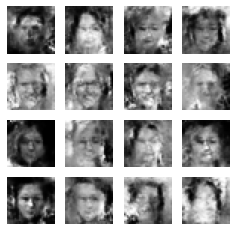

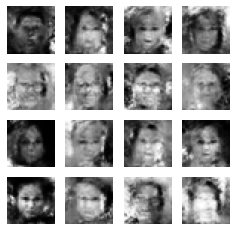

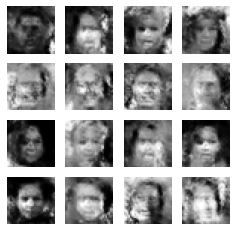

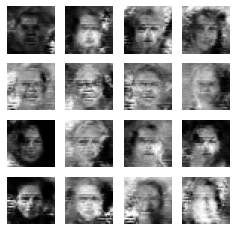

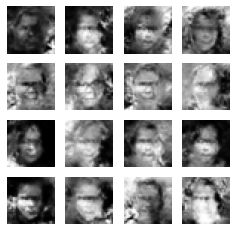

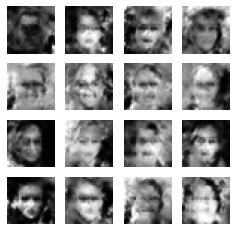

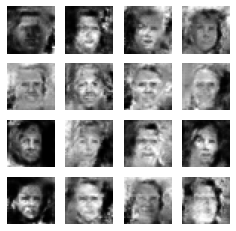

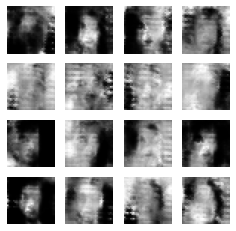

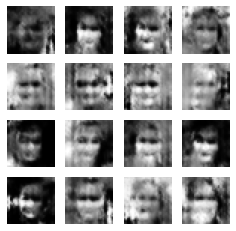

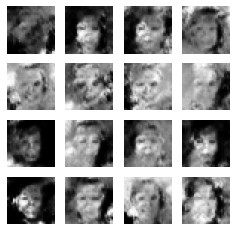

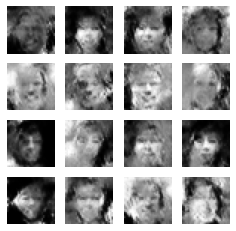

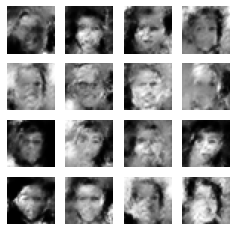

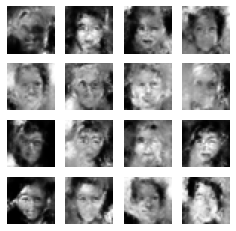

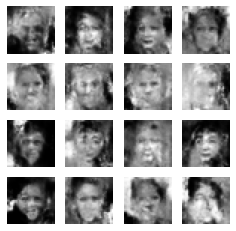

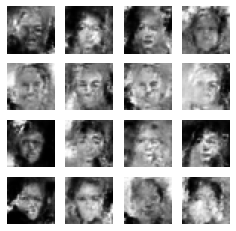

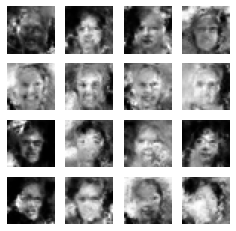

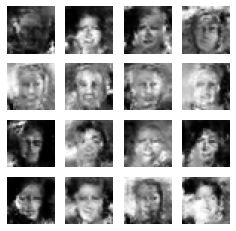

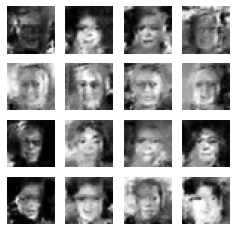

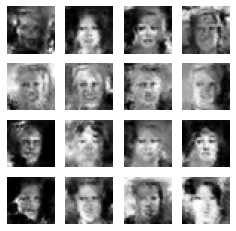

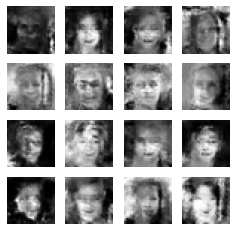

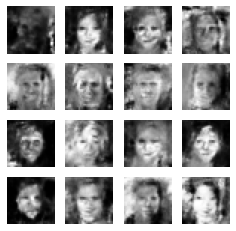

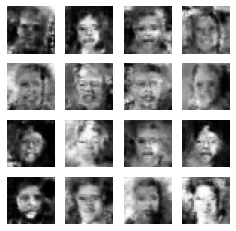

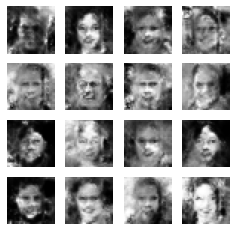

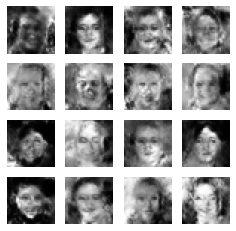

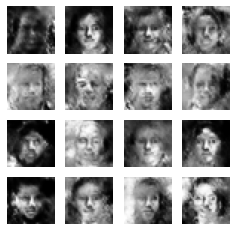

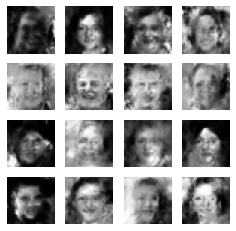

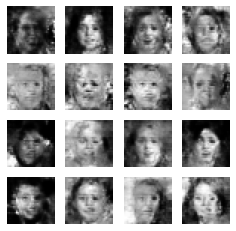

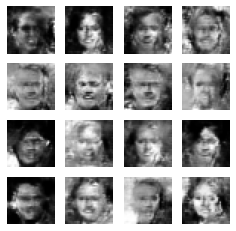

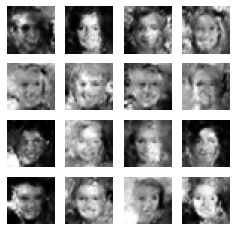

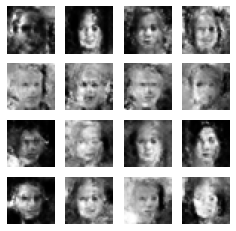

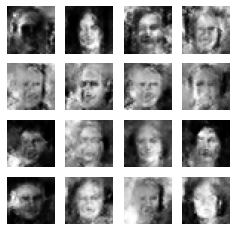

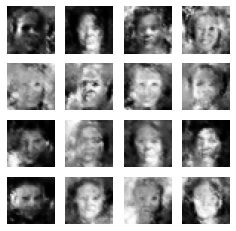

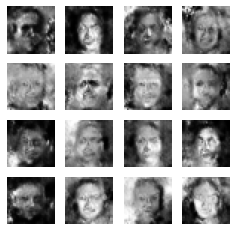

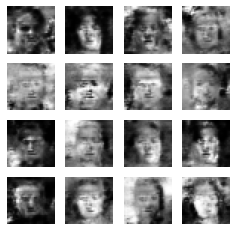

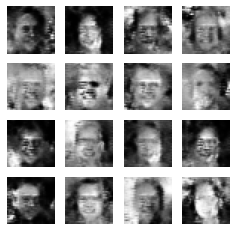

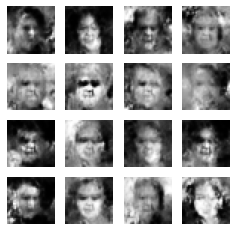

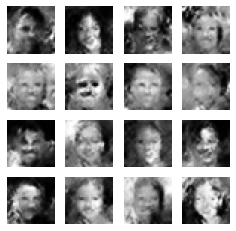

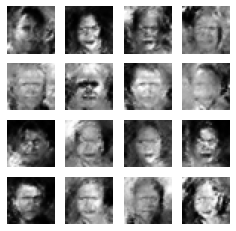

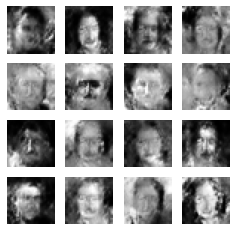

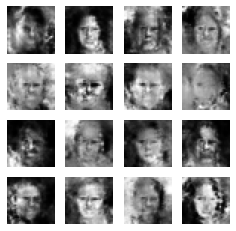

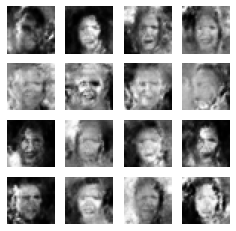

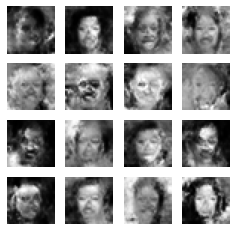

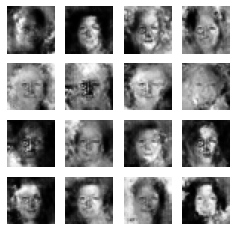

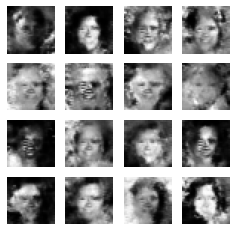

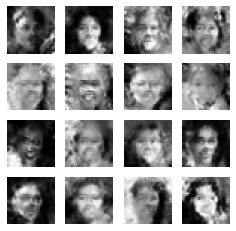

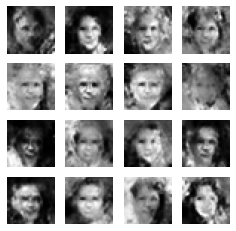

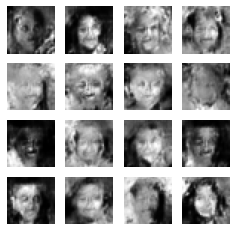

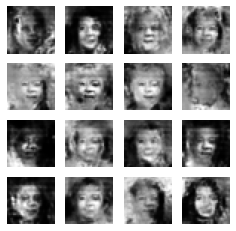

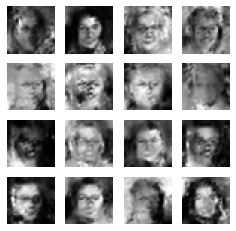

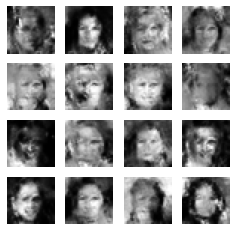

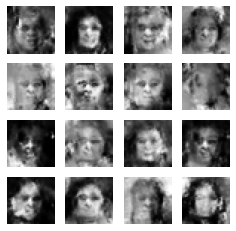

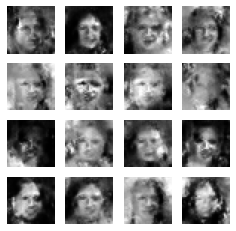

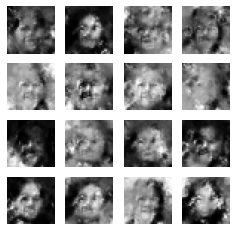

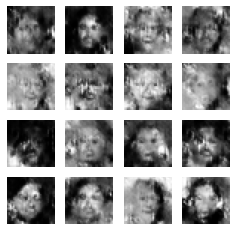

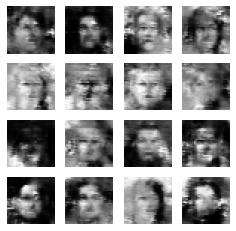

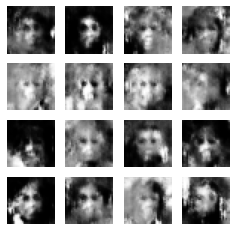

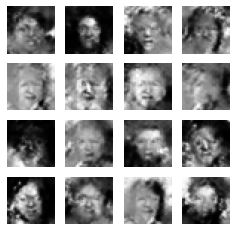

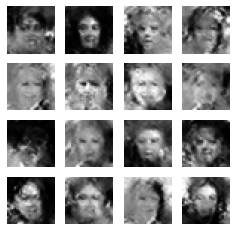

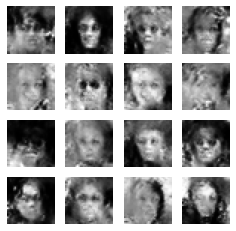

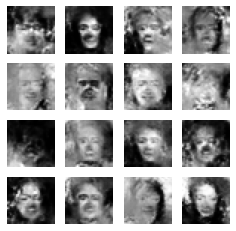

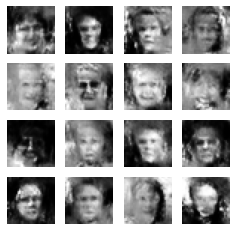

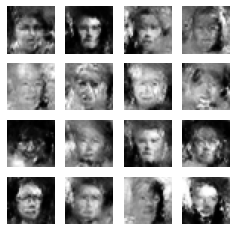

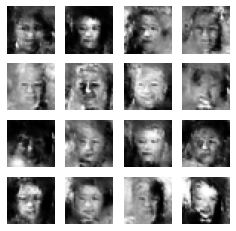

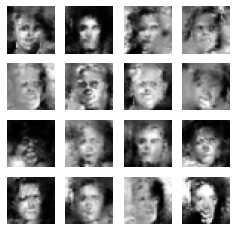

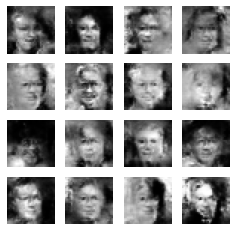

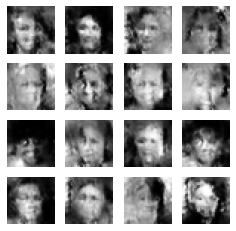

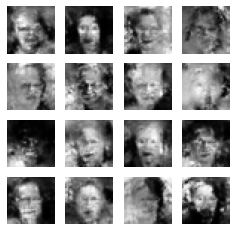

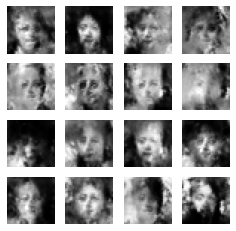

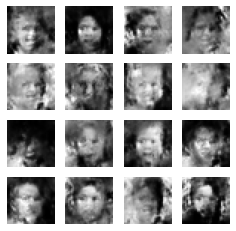

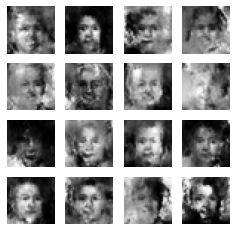

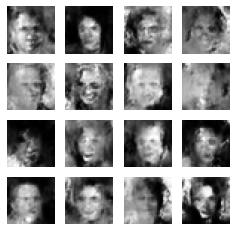

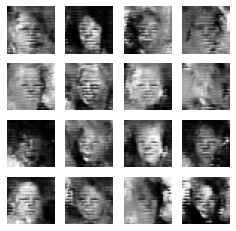

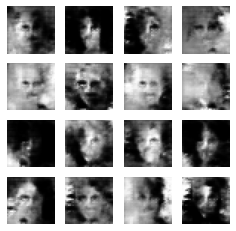

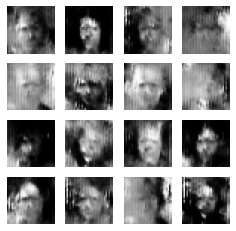

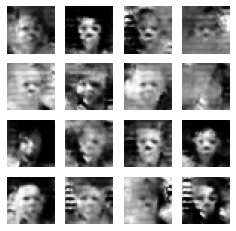

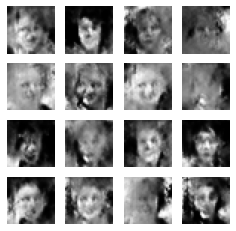

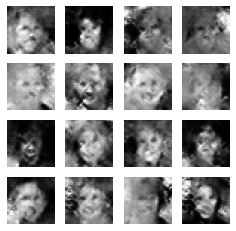

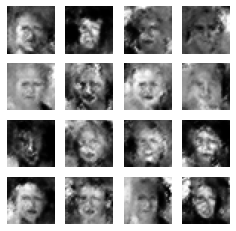

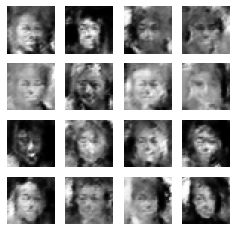

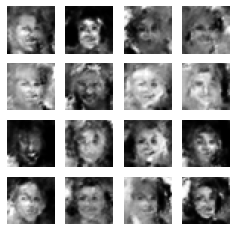

In [124]:
train(train_ds, 100)